In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from torchvision.models import efficientnet_b0
import timm
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import json

In [2]:
df = pd.read_csv("/kaggle/input/dataset-normalis-patients-labels-rayon-x/DB_patients_norm_bbox.csv")

In [3]:
df = pd.read_csv("/kaggle/input/data/BBox_List_2017.csv")

In [3]:
def filtrer_maladie_unique(df, maladie_cible, autres_maladies):
    """
    Retourne les lignes du DataFrame où :
    - maladie_cible == 1
    - toutes les autres maladies == 0
    """
    condition_cible = df[maladie_cible] == 1
    autres = [m for m in autres_maladies if m != maladie_cible]
    condition_autres = df[autres].sum(axis=1) == 0

    return df[condition_cible & condition_autres]

maladies = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding'
]

df_atelectasis_seule = filtrer_maladie_unique(df, "Atelectasis", maladies)
df_no_finding_seule = filtrer_maladie_unique(df, "No Finding", maladies)
df_no_finding_seule = df_no_finding_seule.sample(n=5000, random_state=42)
df_atelectasis_final = pd.concat([df_atelectasis_seule, df_no_finding_seule], ignore_index=True)

In [4]:
df_atelectasis_final["Finding Labels"].value_counts()

Finding Labels
No Finding     5000
Atelectasis    4215
Name: count, dtype: int64

# Dataset

In [6]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        # Convert PIL to grayscale numpy
        img_np = np.array(img.convert('L'))  # convert to grayscale
        img_clahe = self.clahe.apply(img_np)

        # Reconvert to PIL with 3 channels (fake RGB)
        img_rgb = Image.fromarray(cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB))
        return img_rgb

In [5]:
# 1. Dataset PyTorch multi-label
class ChestXrayMultilabelDataset(Dataset):
    def __init__(self, dataframe, label_cols, transform=None):
        self.df = dataframe
        self.label_cols = label_cols
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform    

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['Image Path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels = torch.tensor(row[self.label_cols].astype(np.float32).values, dtype=torch.float32)
        return image, labels

    def __afficher_image__(self, idx):
        """
        Affiche l'image (dénormalisée) et ses labels associés.
        """
        image, label = self[idx]

        # # Dénormalisation
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = image * std + mean  # Inverser la normalisation

        # Passage à la forme (H, W, C) pour matplotlib
        image = image.permute(1, 2, 0).clamp(0, 1)

        # Affichage
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

        # Affichage des maladies détectées
        nb_maladie = 0
        for i in range(len(label)):
            if label[i] == 1:
                print("Maladies présentes :")
                print(f" - {self.label_cols[i]}")
                nb_maladie += 1
        if(nb_maladie == 0):
            print("Aucune maladie")

In [18]:
def detect_lung_roi(image_pil):
    img_gray = np.array(image_pil.convert('L'))  # PIL → grayscale numpy
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    _, thresh = cv2.threshold(img_blur, 30, 255, cv2.THRESH_BINARY)

    # Trouver les contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image_pil  # fallback

    # Récupérer le plus grand contour
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)

    # Crop l'image selon le ROI détecté
    img_cropped = img_gray[y:y+h, x:x+w]
    img_rgb = cv2.cvtColor(img_cropped, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(img_rgb)

class LungROICrop:
    def __call__(self, img):
        return detect_lung_roi(img)

In [64]:
class CenterCropZoom:
    def __init__(self, zoom_factor=1.2):
        self.zoom_factor = zoom_factor

    def __call__(self, img):
        w, h = img.size
        new_w = int(w / self.zoom_factor)
        new_h = int(h / self.zoom_factor)
        left = (w - new_w) // 2
        top = (h - new_h) // 2
        right = left + new_w
        bottom = top + new_h
        img_cropped = img.crop((left, top, right, bottom))
        return img_cropped

In [65]:
transform = transforms.Compose([
    LungROICrop(),
    transforms.Resize((256, 256)),  # Agrandit
    CenterCropZoom(zoom_factor=1.5),  # Zoom centré
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [68]:
# 2. Préparation des données
label_columns = ['Atelectasis']

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


train_dataset = ChestXrayMultilabelDataset(train_df, label_columns, transform)
val_dataset = ChestXrayMultilabelDataset(val_df, label_columns, transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

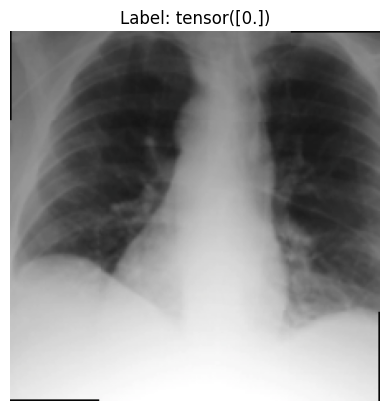

Aucune maladie


In [75]:
train_dataset.__afficher_image__(1585)

In [76]:
# 3. Modèle EfficientNet-B0
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(label_columns))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 126MB/s] 


In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import time
import json
import matplotlib.pyplot as plt

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
patience = 3  # early stopping si pas d'amélioration après X epochs
no_improve_epochs = 0
best_f1 = 0.0
best_metrics = {}

train_losses = []
val_losses = []

start_time = time.time()

# --- Entraînement ---
for epoch in range(30):  # nombre max d'epochs
    print(f"\n🟢 Epoch {epoch+1}")

    # === Entraînement ===
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    pbar = tqdm(train_loader, desc="Train", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = (torch.sigmoid(outputs).detach().cpu().numpy() > 0.5).astype(int)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        pbar.set_postfix(loss=loss.item())

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"🔧 Train Loss: {avg_train_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # === Validation ===
    model.eval()
    val_epoch_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Val", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_epoch_loss += loss.item()

            preds = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(int)
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    acc = accuracy_score(val_labels, val_preds)
    prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

    print(f"🧪 Val   Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # === Sauvegarde si meilleur F1 ===
    if f1 > best_f1:
        best_f1 = f1
        best_metrics = {
            "epoch": epoch + 1,
            "val_loss": avg_val_loss,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        }

        # 💾 Sauvegarde en .pth et .pt
        torch.save(model.state_dict(), "best_model_appa_at.pth")
        torch.save(model, "best_model.pt")
        with open("best_metrics.json", "w") as f:
            json.dump(best_metrics, f, indent=4)

        print("✅ Meilleur modèle sauvegardé !")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        print(f"⚠️ Pas d'amélioration. Patience: {no_improve_epochs}/{patience}")
        if no_improve_epochs >= patience:
            print(f"🛑 Early stopping déclenché après {patience} epochs sans amélioration.")
            break

end_time = time.time()
print(f"\n⏱️ Temps total d'entraînement : {end_time - start_time:.2f} secondes")


🟢 Epoch 1


KeyboardInterrupt: 

In [14]:
torch.save(model.state_dict(), "efficientnet_at_ap_pa2.pth")

In [3]:
def afficher_metrics_json(nom):
    with open(nom, "r") as f:
        metrics = json.load(f)
    
    print("📊 Résultats du modèle :\n")
    
    for key, value in metrics.items():
        if isinstance(value, list):
            print(f"{key} (évolution) :")
            print("  → ", [round(v, 4) for v in value])
        else:
            print(f"{key.capitalize()} : {round(value, 4)}")
    
    if "loss_train" in metrics and "loss_val" in metrics:
        plt.plot(metrics["loss_train"], label="Train Loss")
        plt.plot(metrics["loss_val"], label="Validation Loss")
        plt.xlabel("Époque")
        plt.ylabel("Loss")
        plt.title("Évolution des pertes")
        plt.legend()
        plt.grid(True)
        plt.show()

In [4]:
afficher_metrics_json("/kaggle/working/best_metrics.json")

📊 Résultats du modèle :

Epoch : 4
Val_loss : 0.2669
Accuracy : 0.9005
Precision : 0.7022
Recall : 0.551
F1 : 0.5668


In [9]:
label_columns = ["Atelectasis"]
model1 = efficientnet_b0(pretrained=False)
model1.classifier[1] = nn.Linear(model1.classifier[1].in_features, len(label_columns))

# 2. Charger les poids sur CPU
state_dict = torch.load(
    "/kaggle/working/best_model.pth",
    map_location=torch.device("cpu")
)
model1.load_state_dict(state_dict)

# 3. Mettre sur le bon device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)
model1.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [4]:
model_data = torch.load("/kaggle/input/atelectasis-appa-efficent-b0-./pytorch/default/1/b0_infiltration_appa.pt", map_location="cpu")
print(type(model_data))

<class 'collections.OrderedDict'>


In [6]:
from torchvision.models import efficientnet_b0
import torch
from torchvision.models import efficientnet_b0

# Créer le modèle avec la bonne taille de sortie
model = efficientnet_b0(num_classes=1)

# Charger les poids
state_dict = torch.load("/kaggle/input/atelectasis-appa-efficent-b0-./pytorch/default/1/b0_infiltration_appa.pt", map_location="cpu")
model.load_state_dict(state_dict)

model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
with torch.no_grad():
    output = model(input_tensor)
    prob = torch.sigmoid(output)

NameError: name 'input_tensor' is not defined

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


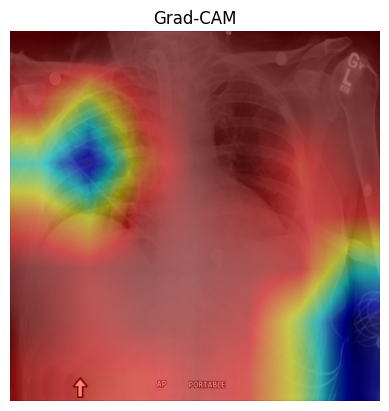

Probabilité de la pathologie : 0.8292


In [14]:
import torch
import torch.nn.functional as F
from torchvision.models import efficientnet_b0
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 1. Charger l’image
def load_image(path):
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0), image

image_path = "/kaggle/input/data/images_002/images/00003392_039.png"  # adapte ce chemin
input_tensor, original_image = load_image(image_path)

# 2. Charger le modèle
model = efficientnet_b0(num_classes=1)
state_dict = torch.load("/kaggle/input/atelectasis-appa-efficent-b0-./pytorch/default/1/b0_infiltration_appa.pt", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

# 3. Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor):
        output = self.model(input_tensor)
        score = output.squeeze()  # binaire
        self.model.zero_grad()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam

# 4. Appliquer Grad-CAM
target_layer = model.features[-1]
grad_cam = GradCAM(model, target_layer)
cam = grad_cam.generate_cam(input_tensor)

# 5. Affichage
cam_resized = cv2.resize(cam, original_image.size)
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(original_image) / 255
overlay = overlay / np.max(overlay)

plt.imshow(overlay)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()

with torch.no_grad():
    output = model(input_tensor)
    prob = torch.sigmoid(output).item()

print(f"Probabilité de la pathologie : {prob:.4f}")

In [13]:
df_atelectasis_final.iloc[1000:1500,:]

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Emphysema,Fibrosis,Pleural_Thickening,Hernia,No Finding,Image Path,x,y,w,h
1000,12963,00003392_038.png,Infiltration,38,3392,62,M,AP,2500,2048,...,0,0,0,0,0,/kaggle/input/data/images_002/images/00003392_...,False,False,False,False
1001,12964,00003392_039.png,Infiltration,39,3392,62,M,AP,2500,2048,...,0,0,0,0,0,/kaggle/input/data/images_002/images/00003392_...,False,False,False,False
1002,12970,00003392_045.png,Infiltration,45,3392,62,M,AP,2500,2048,...,0,0,0,0,0,/kaggle/input/data/images_002/images/00003392_...,False,False,False,False
1003,12974,00003392_049.png,Infiltration,49,3392,62,M,AP,2500,2048,...,0,0,0,0,0,/kaggle/input/data/images_002/images/00003392_...,False,False,False,False
1004,12975,00003392_050.png,Infiltration,50,3392,62,M,AP,2500,2048,...,0,0,0,0,0,/kaggle/input/data/images_002/images/00003392_...,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,20678,00005532_015.png,Infiltration,15,5532,39,F,AP,3056,2544,...,0,0,0,0,0,/kaggle/input/data/images_003/images/00005532_...,False,False,False,False
1496,20684,00005532_021.png,Infiltration,21,5532,41,F,PA,2021,2021,...,0,0,0,0,0,/kaggle/input/data/images_003/images/00005532_...,False,False,False,False
1497,20686,00005532_023.png,Infiltration,23,5532,41,F,PA,2021,2016,...,0,0,0,0,0,/kaggle/input/data/images_003/images/00005532_...,False,False,False,False
1498,20707,00005532_044.png,Infiltration,44,5532,36,F,AP,3000,2540,...,0,0,0,0,0,/kaggle/input/data/images_003/images/00005532_...,False,False,False,False


In [5]:
df_atelectasis_seule = filtrer_maladie_unique(df, "Infiltration", maladies)
df_no_finding_seule = filtrer_maladie_unique(df, "No Finding", maladies)
df_no_finding_seule = df_no_finding_seule.sample(n=5000, random_state=42)
df_atelectasis_final = pd.concat([df_atelectasis_seule, df_no_finding_seule], ignore_index=True)

In [ ]:
from torchvision.models import efficientnet_b0
import torch

# 1. Charger le modèle (architecture seule)
model5 = efficientnet_b0(num_classes=1)  # adapte le nombre de classes

# 2. Charger les poids
state_dict = torch.load("ton_fichier.pth", map_location="cpu")
model5.load_state_dict(state_dict)

# 3. Mettre en mode évaluation
model5.eval()


In [4]:
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN


In [4]:
df[(df["Atelectasis"] == 1) & (df["View Position"] == "PA")]

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Emphysema,Fibrosis,Pleural_Thickening,Hernia,No Finding,Image Path,x,y,w,h
34,34,00000011_006.png,Atelectasis,6,11,75,M,PA,2992,2991,...,0,0,0,0,0,/kaggle/input/data/images_001/images/00000011_...,False,False,False,False
73,73,00000013_035.png,Atelectasis|Pneumothorax,35,13,56,M,PA,2992,2991,...,0,0,0,0,0,/kaggle/input/data/images_001/images/00000013_...,False,False,False,False
92,92,00000019_000.png,Atelectasis|Effusion|Pleural_Thickening,0,19,66,M,PA,2992,2991,...,0,0,1,0,0,/kaggle/input/data/images_001/images/00000019_...,False,False,False,False
111,111,00000030_000.png,Atelectasis,0,30,74,M,PA,2992,2991,...,0,0,0,0,0,/kaggle/input/data/images_001/images/00000030_...,False,False,False,False
112,112,00000030_001.png,Atelectasis,1,30,79,M,PA,2992,2991,...,0,0,0,0,0,/kaggle/input/data/images_001/images/00000030_...,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111964,111964,00030695_003.png,Atelectasis,3,30695,52,F,PA,2021,2021,...,0,0,0,0,0,/kaggle/input/data/images_012/images/00030695_...,False,False,False,False
111969,111969,00030699_000.png,Atelectasis,0,30699,68,F,PA,2021,2021,...,0,0,0,0,0,/kaggle/input/data/images_012/images/00030699_...,False,False,False,False
112050,112050,00030753_010.png,Atelectasis|Effusion,10,30753,55,F,PA,2021,2011,...,0,0,0,0,0,/kaggle/input/data/images_012/images/00030753_...,False,False,False,False
112052,112052,00030753_012.png,Atelectasis|Mass,12,30753,55,F,PA,2021,2021,...,0,0,0,0,0,/kaggle/input/data/images_012/images/00030753_...,False,False,False,False
